In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

import time
from copy import copy
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import norm
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.neighbors import NearestNeighbors

# Locality Sensitive Hashing

In [2]:
wiki = pd.read_csv('people_wiki.csv')
wiki.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


In [3]:
tfidf = TfidfVectorizer(stop_words = ENGLISH_STOP_WORDS)
corpus = tfidf.fit_transform(wiki['text'])
corpus

<59071x548115 sparse matrix of type '<class 'numpy.float64'>'
	with 8078359 stored elements in Compressed Sparse Row format>

## Train an LSH model

LSH performs an efficient neighbor search by randomly partitioning all reference data points into different bins. Today we will build a popular variant of LSH known as random binary projection, which approximates cosine distance. There are other variants we could use for other choices of distance metrics.

The first step is to generate a collection of random vectors from the standard Gaussian distribution. To visualize these Gaussian random vectors, let's look at an example in low-dimensions. Below, we generate 3 random vectors each of dimension 5.

In [4]:
def generate_random_vectors(dim, n_vectors):
    """
    generate random projection vectors
    the dims comes first in the matrix's shape, so we can use it
    for matrix multiplication
    """
    return np.random.randn(dim, n_vectors)

In [5]:
# generate 3 random vectors of dimension 5, arranged into a single 5 x 3 matrix.
np.random.seed(0)
generate_random_vectors(dim = 5, n_vectors = 3)

array([[ 1.76405235,  0.40015721,  0.97873798],
       [ 2.2408932 ,  1.86755799, -0.97727788],
       [ 0.95008842, -0.15135721, -0.10321885],
       [ 0.4105985 ,  0.14404357,  1.45427351],
       [ 0.76103773,  0.12167502,  0.44386323]])

In [6]:
class GaussianProjection:
    """
    http://scikit-learn.org/stable/modules/random_projection.html
    """
    def __init__(self, n_components, seed):
        self.seed = seed
        self.n_components = n_components
        
    def fit(X):
        """generate the random projection"""
        # normal's scale refers to the standard deviation
        # instead of the variance
        rstate = np.random.RandomState(self.seed)
        self.components = rstate.normal( 
            loc = 0, 
            scale = 1 / np.sqrt(n_components),
            size = (n_components, n_features)
        )
        return self
        
    def transform(X):
        X_new =  X.dot(self.components.T)
        return X_new
        
    def fit_transform(X):
        return self.fit(X).transform(X)

We now generate random vectors of the same dimensionality as our vocabulary size. Each vector can be used to compute one bit in the bin encoding. We generate 16 vectors, leading to a 16-bit encoding of the bin index for each document.

In [7]:
vocab_size = corpus.shape[1]
random_vectors = generate_random_vectors(dim = vocab_size, n_vectors = 16)
random_vectors.shape

(548115, 16)

Next, we partition data points into bins. Instead of using for loops, we'll utilize matrix multiplications for greater efficiency. Let's walk through the construction step by step. We'd like to decide which bin document 0 should go. Since 16 random vectors were generated in the previous cell, we have 16 bits to represent the bin index. The first bit is given by the sign of the dot product between the first random vector and the document's TF-IDF vector.

In [8]:
# for document 0, perform a dot product with
# the randomly generated vectors;
# True if positive sign, False if negative sign
doc = corpus[0]
doc.dot(random_vectors[:, 0]) >= 0 

array([False], dtype=bool)

In [9]:
# similarly, we can compute all of the bin index bits at once as follows.
doc.dot(random_vectors) >= 0

array([[False,  True, False, False,  True,  True, False, False,  True,
        False, False, False,  True, False, False,  True]], dtype=bool)

All documents that obtain exactly this vector will be assigned to the same bin. We'd like to repeat the identical operation on all documents in the dataset and compute the corresponding bin indices. Again, we use matrix operations so that no explicit loop is needed.

In [10]:
# compute bit indices of ALL document
corpus.dot(random_vectors) >= 0

array([[False,  True, False, ..., False, False,  True],
       [ True,  True,  True, ..., False, False, False],
       [ True, False,  True, ..., False, False, False],
       ..., 
       [False,  True, False, ..., False,  True,  True],
       [False,  True, False, ..., False,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool)

We're almost done! To make it convenient to refer to individual bins, we convert each binary bin index into a single integer: 
```
Bin index                      integer
[0,0,0,0,0,0,0,0,0,0,0,0]   => 0
[0,0,0,0,0,0,0,0,0,0,0,1]   => 1
[0,0,0,0,0,0,0,0,0,0,1,0]   => 2
[0,0,0,0,0,0,0,0,0,0,1,1]   => 3
...
[1,1,1,1,1,1,1,1,1,1,0,0]   => 65532
[1,1,1,1,1,1,1,1,1,1,0,1]   => 65533
[1,1,1,1,1,1,1,1,1,1,1,0]   => 65534
[1,1,1,1,1,1,1,1,1,1,1,1]   => 65535 (= 2^16-1)
```
By the [rules of binary number representation](https://en.wikipedia.org/wiki/Binary_number#Decimal), we just need to compute the dot product between the document vector and the vector consisting of powers of 2:

In [11]:
# using the first document to print the output
doc = corpus[0]  
index_bits = doc.dot(random_vectors) >= 0

# https://wiki.python.org/moin/BitwiseOperators
# x << y is the same as multiplying x by 2 ** y
powers_of_two = 1 << np.arange(15, -1, step = -1)
print(index_bits)
print(powers_of_two)

# final integer representation of individual bins
print( index_bits.dot(powers_of_two) )

[[False  True False False  True  True False False  True False False False
   True False False  True]]
[32768 16384  8192  4096  2048  1024   512   256   128    64    32    16
     8     4     2     1]
[19593]


In [12]:
# we can do it for the entire corpus
index_bits = corpus.dot(random_vectors) >= 0
index_bits.dot(powers_of_two)

array([19593, 58760, 44104, ..., 21763, 19483, 64159])

This array gives us the integer index of the bins for all documents. Now we are ready to complete the following function. Given the integer bin indices for the documents, we should compile a list of document IDs that belong to each bin. Since a list is to be maintained for each unique bin index, a dictionary of lists is used.

In [22]:
def train_lsh(data, n_vectors, seed = None):
    
    if seed is not None:
        np.random.seed(seed)
    
    # generate random projection
    dim = data.shape[1]
    random_vectors = generate_random_vectors(dim, n_vectors)  
    
    # partition data points into bins,
    # and encode bin index bits into integers
    bin_indices_bits = ( data.dot(random_vectors) >= 0 ).astype(np.int)
    powers_of_two = 1 << np.arange(n_vectors - 1, -1, step = -1)
    bin_indices = bin_indices_bits.dot(powers_of_two)
    
    # update `table` so that `table[i]` is the list of document ids with bin index equal to i
    table = defaultdict(list)
    for idx, bin_index in enumerate(bin_indices):
        table[bin_index].append(idx)

    model = {'data': data,
             'bin_indices_bits': bin_indices_bits,
             'bin_indices': bin_indices,
             'table': table,
             'random_vectors': random_vectors,
             'n_vectors': n_vectors}
    return model

In [56]:
from sklearn.neighbors import NearestNeighbors

# query Barack Obama's top 5 nearest neighbors
nn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
nn.fit(corpus)
obama_index = wiki[ wiki['name'] == 'Barack Obama' ].index[0]
distances, indices = nn.kneighbors(corpus[obama_index], n_neighbors = 5)

# 1. flatten the 2d-array distance and indices to 1d
# 2. merge the distance information with the original wiki dataset, 
#    to obtain the name matching the id.
neighbors = pd.DataFrame({ 'distance': distances.flatten(), 'id': indices.flatten() })
nearest_info = ( wiki
                 .merge(neighbors, right_on = 'id', left_index = True)
                 .sort_values('distance')[['id', 'name', 'distance']] )
nearest_info

,id,name,distance
0,35817,Barack Obama,0.000000
1,24478,Joe Biden,0.678781
2,38376,Samantha Power,0.728871
3,57108,Hillary Rodham Clinton,0.743761
4,38714,Eric Stern (politician),0.747264




In the next code chunk, we'll train the locality sensitive hashing model, after that we can examine the bit representations of the bins containing Barack Obama and Joe Biden and see in how many places do they agree.

In [34]:
# train the model
model = train_lsh(corpus, n_vectors = 16, seed = 143)

# comparison
biden_index = wiki[ wiki['name'] == 'Joe Biden' ].index[0]
obama_bits = model['bin_indices_bits'][obama_index]
biden_bits = model['bin_indices_bits'][biden_index]
print(obama_bits)
print(biden_bits)
print('Number of agreed bins', np.sum(obama_bits == biden_bits))

[0 1 0 1 1 0 1 0 0 0 1 1 1 1 1 0]
[1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0]
Number of agreed bins 9


We then compare the bins of a football player, whose bin representation should agree with Obama's in fewer places. 

In [35]:
morrell_index = wiki[wiki['name'] == 'Digby Morrell'].index[0]
morrell_bits = model['bin_indices_bits'][morrell_index]
print(morrell_bits)
print('Number of agreed bins', np.sum(obama_bits == morrell_bits))

[1 0 1 0 0 1 1 0 1 1 0 1 1 0 0 0]
Number of agreed bins 5


In [37]:
model['table'][model['bin_indices'][obama_index]]

[27551, 35817]

In [50]:
wiki.iloc[27551]

URI     <http://dbpedia.org/resource/Rodrigo_Rivera_Sa...
name                               Rodrigo Rivera Salazar
text    jos rodrigo rivera salazar born 20 april 1963 ...
Name: 27551, dtype: object

In [54]:
from scipy.sparse.linalg import norm

def cosine(x, y):
    xy = x.dot(y.T)
    dist = xy / (norm(x) * norm(y))
    return 1 - dist[0, 0]

obama_tf_idf = corpus[obama_index]
biden_tf_idf = corpus[biden_index]
salazar_tf_idf = corpus[27551]

print( 'Obama - Biden: {0:f}'.format(cosine(obama_tf_idf, biden_tf_idf)) )
print( 'Obama - Salazar: {0:f}'.format(cosine(obama_tf_idf, salazar_tf_idf)) )

Obama - Biden: 0.678781
Obama - Salazar: 0.918916


**Moral of the story**. Similar data points will in general _tend to_ fall into _nearby_ bins, but that's all we can say about LSH. In a high-dimensional space such as text features, we often get unlucky with our selection of only a few random vectors such that dissimilar data points go into the same bin while similar data points fall into different bins. **Given a query document, we must consider all documents in the nearby bins and sort them according to their actual distances from the query.**

## Query the LSH model

Let us first implement the logic for searching nearby neighbors, which goes like this:
```
1. Let L be the bit representation of the bin that contains the query documents.
2. Consider all documents in bin L.
3. Consider documents in the bins whose bit representation differs from L by 1 bit.
4. Consider documents in the bins whose bit representation differs from L by 2 bits.
...
```

To obtain candidate bins that differ from the query bin by some number of bits, we use `itertools.combinations`, which produces all possible subsets of a given list. See [this documentation](https://docs.python.org/3/library/itertools.html#itertools.combinations) for details.
```
1. Decide on the search radius r. This will determine the number of different bits between the two vectors.
2. For each subset (n_1, n_2, ..., n_r) of the list [0, 1, 2, ..., n_vectors-1], do the following:
   * Flip the bits (n_1, n_2, ..., n_r) of the query bin to produce a new bit vector.
   * Fetch the list of documents belonging to the bin indexed by the new bit vector.
   * Add those documents to the candidate set.
```

Each line of output from the following cell is a 3-tuple indicating where the candidate bin would differ from the query bin. For instance,
```
(0, 1, 3)
```
indicates that the candiate bin differs from the query bin in first, second, and fourth bits (indexing starts at 0). With this output in mind, implement the logic for nearby bin search:

In [59]:
def search_nearby_bins(query_bin_bits, table, search_radius, candidate_set = None):
    """
    For a given query vector and trained LSH model, return all candidate neighbors for
    the query among all bins within the given search radius.
    
    Example
    -------
    >>> model = train_lsh(corpus, n_vectors=16, seed=143)
    >>> q = model['bin_index_bits'][0]  # vector for the first document
  
    >>> candidates = search_nearby_bins(q, model['table'])
    """
    if candidate_set is None:
        candidate_set = set()

    n_vectors = query_bin_bits.shape[0]
    powers_of_two = 1 << np.arange(n_vectors - 1, -1, step=-1)

    for different_bits in combinations( range(n_vectors), search_radius ):
        # flip the bits (n_1,n_2,...,n_r) of the query bin to produce a new bit vector
        alternate_bits = copy(query_bin_bits)
        alternate_bits[different_bits] = np.logical_not(alternate_bits[different_bits])
        
        # convert the new bit vector to an integer index
        nearby_bin = alternate_bits.dot(powers_of_two)
        
        # fetch the list of documents belonging to
        # the bin indexed by the new bit vector,
        # then add those documents to candidate_set;
        # make sure that the bin exists in the table
        if nearby_bin in table:
            candidate_set.update(table[nearby_bin])
            
    return candidate_set

In [56]:
obama_bin_index = model['bin_indices_bits'][35817]
obama_bin_index.shape

(16,)

In [61]:
np.logical_not(obama_bin_index)

array([ True, False,  True, False, False,  True, False,  True,  True,
        True, False, False, False, False, False,  True], dtype=bool)

In [57]:
obama_bin_index

array([0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0])

In [59]:
for different_bits in combinations( range(obama_bin_index.shape[0]), 1 ):
    print(different_bits)

(0,)
(1,)
(2,)
(3,)
(4,)
(5,)
(6,)
(7,)
(8,)
(9,)
(10,)
(11,)
(12,)
(13,)
(14,)
(15,)


In [60]:
# bin index of Barack Obama (the boolean vector)
obama_bin_index = model['bin_index_bits'][35817]
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius = 0)

In [65]:
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=1, candidate_set=candidate_set)

Now we have a function that can return all the candidates from neighboring bins. Next we write a function to collect all candidates and compute their true distance to the query.

In [127]:
def query(vec, model, k, max_search_radius):  
    data = model['data']
    table = model['table']
    random_vectors = model['random_vectors']
    n_vectors = random_vectors.shape[1]
        
    # Compute bin index for the query vector, in bit representation.
    bin_index_bits = ( vec.dot(random_vectors) >= 0 ).flatten()
    
    # Search nearby bins and collect candidates
    candidate_set = set()
    for search_radius in range(max_search_radius + 1):
        candidate_set = search_nearby_bins(bin_index_bits, table, search_radius, candidate_set)
    
    # Sort candidates by their true distances from the query
    candidate_list = list(candidate_set)
    candidates = data[candidate_list]
    distance = pairwise_distances(candidates, vec, metric = 'cosine').flatten()

    nearest_neighbors = pd.DataFrame({ 'id': candidate_list, 'distance': distance })
    nearest_neighbors = nearest_neighbors.sort_values('distance').head(k)
    return nearest_neighbors, len(candidate_list)

In [129]:
nearest_neighbors, num_candidates = query(corpus[35817], model, k = 10, max_search_radius = 3)

# merge with the wiki
nearest_info = nearest_neighbors.merge(wiki, left_on = 'id', right_index = True)
nearest_info  

,distance,id,URI,name,text
319,-4.440892e-16,35817,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...
588,8.895507e-01,30440,<http://dbpedia.org/resource/Vincent_Flaherty>,Vincent Flaherty,vince flaherty is an american producer recordi...
496,8.898117e-01,19933,<http://dbpedia.org/resource/David_Cameron>,David Cameron,david william donald cameron kmrn born 9 octob...
404,9.014985e-01,52426,<http://dbpedia.org/resource/Ben_Bernanke>,Ben Bernanke,ben shalom bernanke brnki brnangkee born decem...
451,9.025068e-01,44368,<http://dbpedia.org/resource/Roland_Grossenbac...,Roland Grossenbacher,dr roland edouard grossenbacher is a swiss att...
248,9.135715e-01,43810,<http://dbpedia.org/resource/John_Hogg>,John Hogg,john joseph hogg born 19 march 1949 is an aust...
566,9.143830e-01,5801,<http://dbpedia.org/resource/Paul_A._Trivelli>,Paul A. Trivelli,paul arthur trivelli born 1953 is a united sta...
291,9.145493e-01,25495,<http://dbpedia.org/resource/Ujjal_Dosanjh>,Ujjal Dosanjh,ujjal dev singh dosanjh pc qc udl dosnd born s...
254,9.159734e-01,58163,<http://dbpedia.org/resource/Bernie_Hansen>,Bernie Hansen,bernie hansen born november 26 1944 is a forme...
224,9.261890e-01,708,<http://dbpedia.org/resource/David_N._Kelley>,David N. Kelley,david n kelley born december 1 1959 is an amer...


In [132]:
nearest_neighbors.iloc[0:]

,distance,id
319,-4.440892e-16,35817
588,8.895507e-01,30440
496,8.898117e-01,19933
404,9.014985e-01,52426
451,9.025068e-01,44368
248,9.135715e-01,43810
566,9.143830e-01,5801
291,9.145493e-01,25495
254,9.159734e-01,58163
224,9.261890e-01,708


We have shown that we have a working LSH implementation!


# Experimenting LSH

In the following sections we have implemented a few experiments so that you can gain intuition for how your LSH implementation behaves in different situations. This will help you understand the effect of searching nearby bins and the performance of LSH versus computing nearest neighbors using a brute force search.

## Effect of nearby bin search

How does nearby bin search affect the outcome of LSH? There are three variables that are affected by the search radius:
- Number of candidate documents considered
- Query time
- Distance of approximate neighbors from the query

Let us run LSH multiple times, each with different radius for nearby bin search. We will measure the three variables as discussed above.

In [135]:
query_time_history = []
num_candidates_history = []
max_distance_from_query_history = []
min_distance_from_query_history = []
average_distance_from_query_history = []

for max_search_radius in range(17):
    start = time.time()
    result, num_candidates = query(corpus[35817,:], model, k=10,
                                   max_search_radius=max_search_radius)
    end = time.time()
    query_time = end - start
    
    # the closest neighbor is the query point itself, thus
    # we'll exclude it from the calculation
    distances = result['distance'].iloc[1:]
    max_distance_from_query = distances.max()
    min_distance_from_query = distances.min()
    average_distance_from_query = distances.mean()
    
    query_time_history.append(query_time)
    num_candidates_history.append(num_candidates)     
    max_distance_from_query_history.append(max_distance_from_query)
    min_distance_from_query_history.append(min_distance_from_query)
    average_distance_from_query_history.append(average_distance_from_query)

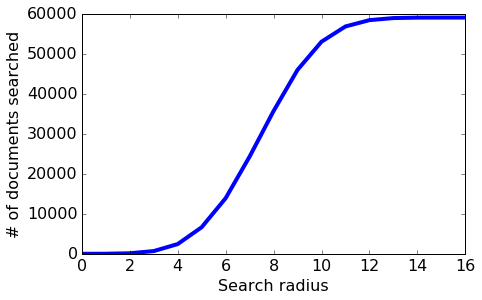

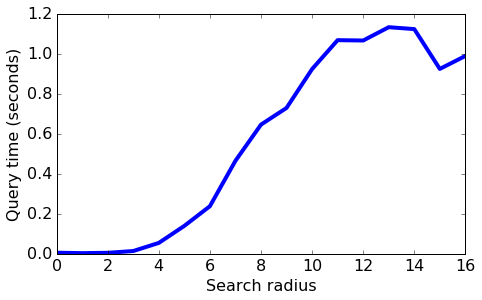

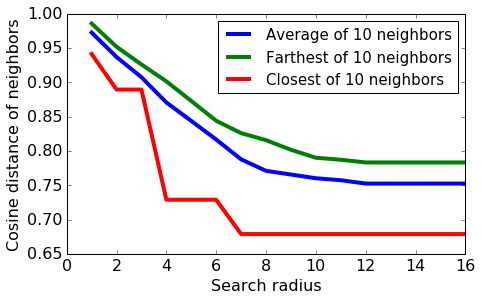

In [136]:
plt.figure(figsize=(7,4.5))
plt.plot(num_candidates_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('# of documents searched')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(query_time_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(average_distance_from_query_history, linewidth=4, label='Average of 10 neighbors')
plt.plot(max_distance_from_query_history, linewidth=4, label='Farthest of 10 neighbors')
plt.plot(min_distance_from_query_history, linewidth=4, label='Closest of 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance of neighbors')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

Some observations:
- As we increase the search radius, we find more neighbors that are a smaller distance away.
- With increased search radius comes a greater number documents that have to be searched. Query time is higher as a consequence.
- With sufficiently high search radius, the results of LSH begin to resemble the results of brute-force search.